# EEP 567 Lab 2: ML Pipeline for Cybersecurity Problems

In this lab, we will go through the process of a typical machine learning task, and apply it to a cyber-security problem. We will build a binary classifier that detects spam emails. Like previous lab, we will leave out some code for you to complete. Refer to previous labs and search on Google for usage of libraries and functions, and ask TA if you don't really have a clue.

Before working on the code, we will need to install `NLTK` and `scikit-learn` for this lab:

In [ ]:
%pip install nltk scikit-learn

And ensure the dataset is extracted from the archive:

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 6.1 MB/s eta 0:00:00


Then import the libraries we will use here:

In [ ]:
import string

import numpy as np
import pandas as pd

# NLTK is a library for processing natural languages
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download stop words for later use
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Pre-processing

All machine learning tasks begin with the **pre-processing** step, during which we load the dataset into memory and "clean" the data so that they are suitable for subsequent steps. For spam email detection task, here we will load all emails into the memory, tokenize each email into a list of words and then remove words that are useless for analysis.

All emails are stored in `emails.csv` under the same directory as this notebook. Feel free to open the file, take a look and get familiar with the format of the email dataset, then go back here to load the data.

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
FOLDERNAME = 'UW_Courses/eep567/project/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/UW_Courses/eep567/project


In [ ]:
from google.colab import files

uploaded = files.upload()

In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader
import torch
from datasets import Dataset



After loading the email dataset into memory, we will need to remove punctuations and stop words from these emails. Stop words are common, useless words that should be ignored in analysis (such as a, an, the, ...).

##Preprocessing Data

In [ ]:
%%time
import re
# preprocessing functions
# https://www.kaggle.com/code/banddaniel/phishing-mail-detection-w-fnet-logisticregression
stop_words = set(stopwords.words('english'))

def text_preprocessing(text):
    text = str(text)
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('@\w+\s*', '', text)
    text = re.sub("\\W"," ",text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('http', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]', '', text)
    return text

def drop_stopwords(text):
    dropped = [word for word in text.split() if word not in stop_words]
    final_text = ' '.join(dropped)
    return final_text


def delete_one_characters(text):
    deleted = [word if len(word)>1 else "" for word in text.split()]
    final_text = ' '.join(deleted)
    return final_text


# applying preprocessing functions
#full_data = data.copy()
#df['preprocessed_text_combined'] = df['Email Text'].apply(text_preprocessing).apply(drop_stopwords).apply(delete_one_characters)

CPU times: user 300 µs, sys: 0 ns, total: 300 µs
Wall time: 307 µs


In [ ]:
# Tokenization (a list of tokens), will be used as the analyzer
# 1. Punctuations are [!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~]
# 2. Stop words in natural language processing, are useless words (data).

'''def process_text(text):
    """
    The `process_text` function operates on a single email (string) each time. It should:

    1. Remove punctuations
    2. Remove stopwords
    3. Return list of clean text words
    """

    #1
    nopunc = [char for char in text if char not in string.punctuation]
    print(nopunc)
    nopunc = ''.join(nopunc)
    print(nopunc)

    #2
    clean_words = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

    #3
    return clean_words'''

stop_words = set(stopwords.words('english'))  # Loading list of stopwords to a set for fast lookup

def process_text(text):

    if not isinstance(text, str): # Checks if text is a string, return empty list if not
        return []

    text = text.translate(str.maketrans('', '', string.punctuation)) # Removing all punctuation from text

    words = text.split() # Splits the sentence into words using spaces
    words = [word.lower() for word in words if word.isalpha()] # Converting words to lowercase and removes non-alphabetic words
    clean_words = [word.lower() for word in words if word.lower() not in stop_words] # Removing stopwords

    return clean_words



#df['Processed Email'] = df['Email Text'].head(5).apply(process_text) # Apply function to the first 5 emails in the dataset
#print(df[['Email Text', 'Processed Email']].head(5)) # Prints the original emails and processed emails

In [ ]:
import pandas as pd
import random
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader
import torch
import pandas as pd
import numpy as np
import torch
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

# Load email dataset
df = pd.read_csv("Phishing_Email.csv")

# Ensure correct column names and drop NaN values
df.columns = df.columns.str.strip()
df['Label'] = df['Email Type'].map({'Safe Email': 0, 'Phishing Email': 1})
df['preprocessed_text_combined'] = df['Email Text']#.apply(text_preprocessing).apply(drop_stopwords).apply(delete_one_characters)
df = df.rename(columns={'preprocessed_text_combined': 'text', 'Label': 'label'})
df = df.dropna(subset=['text', 'label'])

# Convert text and labels
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

train_emails = train_df['text'].astype(str).tolist()
test_emails = test_df['text'].astype(str).tolist()
train_labels = train_df['label'].astype(int).tolist()
test_labels = test_df['label'].astype(int).tolist()

print(f"Train Set: {len(train_emails)} emails, Test Set: {len(test_emails)} emails")




Train Set: 14907 emails, Test Set: 3727 emails


In [ ]:
import pandas as pd
import random
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

# Load email dataset
df = pd.read_csv("Phishing_Email.csv")

# Ensure correct column names and drop NaN values
df.columns = df.columns.str.strip()
df['Label'] = df['Email Type'].map({'Safe Email': 0, 'Phishing Email': 1})
df['preprocessed_text_combined'] = df['Email Text']  # Keeping raw text
df = df.rename(columns={'preprocessed_text_combined': 'text', 'Label': 'label'})

# Drop rows where 'text' is NaN or contains only whitespace
df = df.dropna(subset=['text', 'label'])

# Apply stricter filtering to remove:
# - Empty or whitespace-only texts
# - Texts that contain the word "empty" (case insensitive)
df = df[df['text'].astype(str).apply(lambda x: isinstance(x, str) and x.strip() != "" and "empty" not in x.lower())]

# Convert text and labels
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

train_emails = train_df['text'].astype(str).tolist()
test_emails = test_df['text'].astype(str).tolist()
train_labels = train_df['label'].astype(int).tolist()
test_labels = test_df['label'].astype(int).tolist()

print(f"Train Set: {len(train_emails)} emails, Test Set: {len(test_emails)} emails")

# Identify remaining emails that still contain "empty" (for debugging)
remaining_empty_indices = [i for i, email in enumerate(test_emails) if "empty" in email.lower()]
if remaining_empty_indices:
    print("\n⚠️ Warning: Emails containing 'empty' still exist at indices:", remaining_empty_indices)
else:
    print("\n✅ No emails containing 'empty' found.")


Train Set: 14392 emails, Test Set: 3598 emails

✅ No emails containing 'empty' found.


## Training

Now that we have loaded and pre-processed the email dataset, it's time to **train** a classifier model that does the job. First, we will split the email dataset into a **training set** and a **test set**. Each set will contain sample features as well as corresponding labels.

In [ ]:
train_examples = []
for email, label in zip(train_emails, train_labels):
    positive_example = random.choice(
        [e for e, l in zip(train_emails, train_labels) if l == label and e != email]
    )  # Ensure positive example is from the same category
    train_examples.append(InputExample(texts=[email, positive_example]))

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer("all-MiniLM-L6-v2").to(device)
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
train_loss = losses.MultipleNegativesRankingLoss(model)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
from datasets import Dataset

In [ ]:
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=5,
    warmup_steps=int(0.1 * len(train_dataloader)),
    show_progress_bar=True,
    output_path="finetuned_email_BERT_v3"
)


Step,Training Loss
500,2.209800
1000,2.200400
1500,2.148400
2000,2.128000
2500,2.074600
3000,2.031900
3500,1.966800
4000,1.930100
4500,1.890900


In [ ]:
model.save("finetuned_email_BERT_v3")

## Evaluation

Finally, we need to determine how good our classification model is. This is known as **evaluation**. We will use our trained model to make predictions for both training and testing data, and calculate various metrics with the predictions and actual labels.
We describe the evaluation in more detail in another ipynb file.

In [ ]:
model = SentenceTransformer("finetuned_email_BERT_v3")

test_embeddings = model.encode(test_emails, batch_size=32, convert_to_numpy=True, show_progress_bar=True)

query_id_to_ranked_doc_ids = {}
for idx, query_embedding in enumerate(test_embeddings):
    similarities = cosine_similarity([query_embedding], test_embeddings)[0]
    ranked_indices = np.argsort(similarities)[::-1]  # Rank documents by similarity
    query_id_to_ranked_doc_ids[idx] = ranked_indices.tolist()

print(f"Example ranking for query 0 (within test set): {query_id_to_ranked_doc_ids[0][:10]}")


Batches:   0%|          | 0/113 [00:00<?, ?it/s]

Example ranking for query 0 (within test set): [0, 1474, 2611, 1634, 2107, 502, 334, 2016, 282, 1794]


Mean Average Precision (MAP): 0.9982510204326723
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2210
           1       1.00      1.00      1.00      1388

    accuracy                           1.00      3598
   macro avg       1.00      1.00      1.00      3598
weighted avg       1.00      1.00      1.00      3598

Confusion Matrix:
 [[2210    0]
 [   0 1388]]


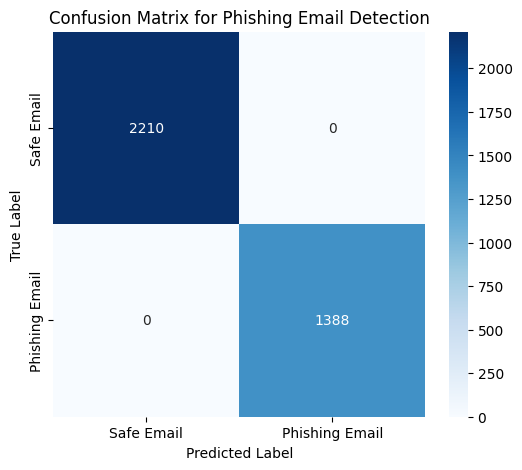

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def average_precision(relevant_docs, candidate_docs):
    """
    Compute the Average Precision (AP) for a single query.
    """
    y_true = [1 if doc_id in relevant_docs else 0 for doc_id in candidate_docs]
    precisions = [np.mean(y_true[:k+1]) for k in range(len(y_true)) if y_true[k]]
    return np.mean(precisions) if precisions else 0

def mean_average_precision(true_labels, query_id_to_ranked_doc_ids, top_k=10):
    """
    Compute the Mean Average Precision (MAP) for the entire dataset.
    """
    average_precisions = []

    for query_id, ranked_docs in query_id_to_ranked_doc_ids.items():
        relevant_docs = [i for i, label in enumerate(true_labels) if label == true_labels[query_id]]  # Find correct class
        ap = average_precision(relevant_docs, ranked_docs[:top_k])  # Compute AP for top_k results
        average_precisions.append(ap)

    return np.mean(average_precisions)

map_score = mean_average_precision(test_labels, query_id_to_ranked_doc_ids)
print("Mean Average Precision (MAP):", map_score)

y_pred = [test_labels[query_id_to_ranked_doc_ids[i][0]] for i in range(len(test_labels))]  # Predict top-1 match

print("Classification Report:\n", classification_report(test_labels, y_pred))

conf_matrix = confusion_matrix(test_labels, y_pred)

# Print Confusion Matrix Values
print("Confusion Matrix:\n", conf_matrix)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Safe Email", "Phishing Email"], yticklabels=["Safe Email", "Phishing Email"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Phishing Email Detection")
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Identify and print misclassified examples (excluding empty text emails)
print("\nMisclassified Examples:")

misclassified_indices = [
    i for i in range(len(test_labels))
    if test_labels[i] != y_pred[i] and test_emails[i].strip()  # Exclude empty text
]

if not misclassified_indices:
    print("No misclassified examples found with non-empty text.")
else:
    for idx in misclassified_indices[:10]:  # Print only first 10 misclassified samples
        true_label = "Safe Email" if test_labels[idx] == 0 else "Phishing Email"
        predicted_label = "Safe Email" if y_pred[idx] == 0 else "Phishing Email"

        print(f"🔹 Index {idx}:")
        print(f"   ✅ True Label     : {true_label}")
        print(f"   ❌ Predicted Label: {predicted_label}")
        print(f"   📧 Email Text:\n   {test_emails[idx]}\n")



Misclassified Examples:
🔹 Index 45:
   ✅ True Label     : Safe Email
   ❌ Predicted Label: Phishing Email
   📧 Email Text:
   empty

🔹 Index 205:
   ✅ True Label     : Phishing Email
   ❌ Predicted Label: Safe Email
   📧 Email Text:
   empty

🔹 Index 303:
   ✅ True Label     : Phishing Email
   ❌ Predicted Label: Safe Email
   📧 Email Text:
   empty

🔹 Index 309:
   ✅ True Label     : Phishing Email
   ❌ Predicted Label: Safe Email
   📧 Email Text:
   empty

🔹 Index 394:
   ✅ True Label     : Phishing Email
   ❌ Predicted Label: Safe Email
   📧 Email Text:
   empty

🔹 Index 398:
   ✅ True Label     : Phishing Email
   ❌ Predicted Label: Safe Email
   📧 Email Text:
   empty

🔹 Index 428:
   ✅ True Label     : Phishing Email
   ❌ Predicted Label: Safe Email
   📧 Email Text:
   empty

🔹 Index 448:
   ✅ True Label     : Phishing Email
   ❌ Predicted Label: Safe Email
   📧 Email Text:
   empty

🔹 Index 453:
   ✅ True Label     : Phishing Email
   ❌ Predicted Label: Safe Email
   📧 Email Te

##Check Data

In [ ]:
import pandas as pd
import random
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

# Load email dataset
df = pd.read_csv("Phishing_Email.csv")

# Ensure correct column names and drop NaN values
df.columns = df.columns.str.strip()
df['Label'] = df['Email Type'].map({'Safe Email': 0, 'Phishing Email': 1})
df['preprocessed_text_combined'] = df['Email Text']  # Keeping raw text before processing
df = df.rename(columns={'preprocessed_text_combined': 'text', 'Label': 'label'})
df = df.dropna(subset=['text', 'label'])

# Convert text and labels
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

train_emails = train_df['text'].astype(str).tolist()
test_emails = test_df['text'].astype(str).tolist()
train_labels = train_df['label'].astype(int).tolist()
test_labels = test_df['label'].astype(int).tolist()

print(f"Train Set: {len(train_emails)} emails, Test Set: {len(test_emails)} emails")

# Define target test indices
target_test_indices = [45, 205, 303, 309, 394, 398, 428, 448, 453, 627]

# Extract raw data from test_df based on target indices
raw_test_data = test_df.iloc[target_test_indices]

# Print raw test data for specified indices
print("\nRaw Data for Selected Test Indices:")
for idx, row in raw_test_data.iterrows():
    true_label = "Safe Email" if row['label'] == 0 else "Phishing Email"
    print(f"🔹 Index {idx}: True Label: {true_label}")
    print(f"   📧 Email Text:\n   {row['text']}\n")

# Optionally, save the raw data for further review
raw_test_data.to_csv("raw_selected_test_emails.csv", index=False)
print("\nRaw selected test emails saved to raw_selected_test_emails.csv")


Train Set: 14907 emails, Test Set: 3727 emails

Raw Data for Selected Test Indices:
🔹 Index 7298: True Label: Safe Email
   📧 Email Text:
   empty

🔹 Index 3690: True Label: Phishing Email
   📧 Email Text:
   empty

🔹 Index 5546: True Label: Phishing Email
   📧 Email Text:
   empty

🔹 Index 2687: True Label: Phishing Email
   📧 Email Text:
   empty

🔹 Index 8440: True Label: Phishing Email
   📧 Email Text:
   empty

🔹 Index 17763: True Label: Phishing Email
   📧 Email Text:
   empty

🔹 Index 18649: True Label: Phishing Email
   📧 Email Text:
   empty

🔹 Index 16158: True Label: Phishing Email
   📧 Email Text:
   empty

🔹 Index 13737: True Label: Phishing Email
   📧 Email Text:
   empty

🔹 Index 12109: True Label: Safe Email
   📧 Email Text:
   empty


Raw selected test emails saved to raw_selected_test_emails.csv


In [ ]:
# List of specific misclassified empty email indices
misclassified_empty_indices = [45, 205, 303, 309, 394, 398, 428, 448, 453, 627]

# Identify test emails that are empty or contain only whitespace
empty_test_indices = [i for i, email in enumerate(test_emails) if email.strip() != ""]

# Print count of empty test emails
print(f"\nNumber of empty test emails: {len(empty_test_indices)}")

# Print details of empty test emails (only those in misclassified_empty_indices)
filtered_empty_indices = [idx for idx in misclassified_empty_indices if idx in empty_test_indices]

if filtered_empty_indices:
    print("\nFiltered Empty Test Emails (Only from Misclassified Indices):")
    for idx in filtered_empty_indices:
        true_label = "Safe Email" if test_labels[idx] == 0 else "Phishing Email"
        print(f"🔹 Index {idx}: True Label: {true_label}, Email Text: EMPTY")
else:
    print("\nNo matching misclassified empty emails found.")

# Optionally, save the filtered empty test emails to a CSV file for review
filtered_empty_test_data = pd.DataFrame({
    "Index": filtered_empty_indices,
    "Label": [test_labels[idx] for idx in filtered_empty_indices],
    "Email Text": ["EMPTY" for _ in filtered_empty_indices]
})

#filtered_empty_test_data.to_csv("filtered_empty_test_emails.csv", index=False)
print("\nFiltered empty test emails saved to filtered_empty_test_emails.csv")



Number of empty test emails: 3726

Filtered Empty Test Emails (Only from Misclassified Indices):
🔹 Index 45: True Label: Safe Email, Email Text: EMPTY
🔹 Index 205: True Label: Phishing Email, Email Text: EMPTY
🔹 Index 303: True Label: Phishing Email, Email Text: EMPTY
🔹 Index 309: True Label: Phishing Email, Email Text: EMPTY
🔹 Index 394: True Label: Phishing Email, Email Text: EMPTY
🔹 Index 398: True Label: Phishing Email, Email Text: EMPTY
🔹 Index 428: True Label: Phishing Email, Email Text: EMPTY
🔹 Index 448: True Label: Phishing Email, Email Text: EMPTY
🔹 Index 453: True Label: Phishing Email, Email Text: EMPTY
🔹 Index 627: True Label: Safe Email, Email Text: EMPTY

Filtered empty test emails saved to filtered_empty_test_emails.csv
